# Generate cellxgene

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

# Prepare INPUT

## Load raw and annoted andata

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

### Read in Sanger dataset

In [8]:
sanger = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')
sanger = sanger[['female' in i for i in sanger.obs.sex]]
sanger.X.shape

(31862, 24482)

### Read in Niu dataset

In [9]:
niu = sc.read('/nfs/team292/vl6/Mouse_Niu2020/mouse_annotated.h5ad')
niu = anndata.AnnData(X=niu.raw.X, var=niu.raw.var, obs=niu.obs, asview=False)

### Merged

In [10]:
sanger.obs['dataset'] = 'Sanger'
niu.obs['dataset'] = 'Niu2020'
niu.obs['sex'] = 'female'
niu.obs['location'] = 'gonad'
adata = sanger.concatenate(niu,
                    batch_key = 'dataset', 
                batch_categories = ['Sanger', 'Niu2020'], 
                                  join = 'outer')

Trying to set attribute `.obs` of view, copying.


In [11]:
adata_annotated = sc.read(path_to_gonads+'/mouse-gonads_female.h5ad')
adata_annotated.X.shape

(74644, 25834)

### Import lineage and somatic annotation

In [12]:
cell_annot = adata_annotated.obs['lineage'].to_dict()
adata.obs['lineage'] = adata.obs_names.map(cell_annot)
adata.obs['lineage'].value_counts()

preGranulosa          13228
Mesenchymal_Lhx9      12828
Mesenchymal_Gata2     12457
Supporting             5667
CoelEpi_Lhx9           5548
GermCells              5373
Epithelial             4814
lowQC                  3698
CoelEpi_Gata2          3363
Mesenchymal_Crabp1     1491
Endothelial            1371
Immune                  979
Erythroid               911
Muscoskeletal           834
Neural                  671
Epithelial_Wnt7a        508
cont                    453
PV                      336
Doublet                 114
Name: lineage, dtype: int64

In [13]:
# Add somatic cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_somatic_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['lineageSomatic'] = adata.obs_names.map(cell_annot)
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].fillna(adata.obs['lineage'])
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].astype('category')
adata.obs['lineageSomatic'].value_counts()

Mesenchymal_Gata2        12457
preGC_II                  7548
Oi                        7531
GermCells                 5373
Gi                        5155
Epithelial                4814
preGC_I                   4659
lowQC                     4117
CoelEpi_Lhx9              3938
early_supporting          3151
CoelEpi_Gata2             3077
granulosa                 1914
Mesenchymal_Crabp1        1491
sPAX8                     1413
Endothelial               1371
OSE                       1031
Immune                     979
Erythroid                  911
Muscoskeletal              834
Neural                     671
cont                       670
Epithelial_Wnt7a           508
CoelEpi_Gata2_cycling      418
PV                         336
Doublet                    148
Ti                         126
Sertoli                      2
FetalLeydig                  1
Name: lineageSomatic, dtype: int64

## Remove lowQC cells and artifacts

In [14]:
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
# adata = adata[[i not in ['lowQC', 'Doublet', 'cont', 'Mesenchymal_Lhx9', 'Supporting'] for i in adata.obs.lineageSomatic]]

In [15]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['lineageSomatic'].values.describe()

Total number of cells: 70379
Total number of genes: 26455


,counts,freqs
categories,,
CoelEpi_Gata2,3077,0.043720
CoelEpi_Gata2_cycling,418,0.005939
CoelEpi_Lhx9,3938,0.055954
Doublet,34,0.000483
Endothelial,1371,0.019480
Epithelial,4814,0.068401
Epithelial_Wnt7a,508,0.007218
Erythroid,911,0.012944
FetalLeydig,1,0.000014


## Import UMAP

In [16]:
adata_annotated = adata_annotated[[ i in adata.obs_names for i in adata_annotated.obs_names ]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
adata.obsm['X_umap'] = adata_annotated.obsm['X_umap']
adata.obsm['X_scVI'] = adata_annotated.obsm['X_scVI']
# adata.obsp['connectivities'] = adata_annotated.obsp['connectivities']
# adata.obsp['distances'] = adata_annotated.obsp['distances']
# adata.uns['celltype_colors'] = adata_annotated.uns['celltype_colors']
# adata.uns['neighbors'] = adata_annotated.uns['neighbors']

## Remove un necessary data

In [18]:
del adata_annotated

In [19]:
adata.obs.head()

,n_genes,sample,stage,sex,location,percent_mito,n_counts,batch,S_score,G2M_score,...,is_doublet,scmap_fromHuman,lineage,dataset,tissue,doublet_score,doublet_score_0.75,leiden,cell_type,lineageSomatic
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger,5003,HCA_Mou_10828699,12.5,female,gonad,0.020128,17091.0,2,-1.202632,-2.036626,...,0,CoelEpi_LHX9,Supporting,Sanger,NaN,NaN,NaN,NaN,NaN,preGC_I
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger,5365,HCA_Mou_10828699,12.5,female,gonad,0.024508,20116.0,2,-1.200000,-1.985430,...,0,preGC_IIa,Supporting,Sanger,NaN,NaN,NaN,NaN,NaN,preGC_I
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger,3916,HCA_Mou_10828699,12.5,female,gonad,0.012982,11786.0,2,-0.273684,-0.992594,...,0,Gi,Mesenchymal_Lhx9,Sanger,NaN,NaN,NaN,NaN,NaN,Oi
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger,4712,HCA_Mou_10828699,12.5,female,gonad,0.020697,15123.0,2,0.636842,-1.602431,...,0,Gi,Mesenchymal_Lhx9,Sanger,NaN,NaN,NaN,NaN,NaN,Gi
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger,5106,HCA_Mou_10828699,12.5,female,gonad,0.025132,18940.0,2,-0.647368,-2.279562,...,0,CoelEpi_LHX9,Supporting,Sanger,NaN,NaN,NaN,NaN,NaN,early_supporting


In [20]:
del adata.obs['scmap_fromHuman']
del adata.obs['tissue']
del adata.obs['leiden']
del adata.obs['cell_type']
del adata.obs['doublet_score']
del adata.obs['doublet_score_0.75']

# Normalize data

In [21]:
adata.raw = adata.copy()

In [22]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)                                                                                                            
# sc.pp.scale(adata, max_value=10)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'sex' as categorical
... storing 'location' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical
... storing 'lineage' as categorical
... storing 'highly_variable-Sanger' as categorical


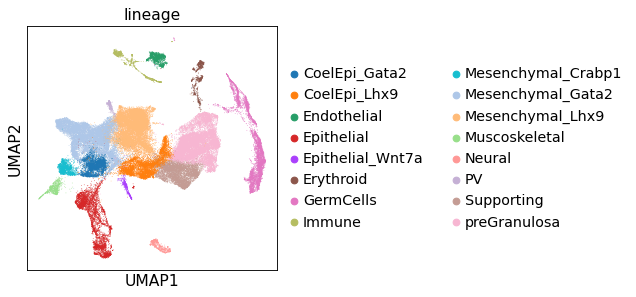

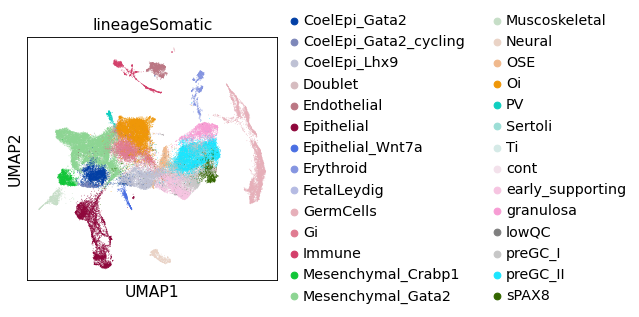

In [23]:
sc.pl.umap(adata, color='lineage')
sc.pl.umap(adata, color='lineageSomatic')

In [25]:
adata.write('/nfs/cellgeni/tickets/tic-613/mouse_main_female.h5ad')